# Climate-Friendly Food Systems (CFFS) Labelling Project

### The University of British Columbia

***

## Part V: Labelling Recipes

## Set up and Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
from configparser import ConfigParser

In [2]:
# RUN ONLY ONCE
# os.chdir is used to change the current directory to the specified path
os.chdir("../") # Sets path to the repo folder as it is one level above where this file exists!
path = os.getcwd()
print(path)

/Users/vivaanwadhwa/Documents/GitHub/CFFS_sharon_2024


## Set Baselines

Make sure to run ```Label_Baseline_Calculation/baseline_OK.ipynb``` if there is a change in the baseline calculation or if a new parameter is added, update accordingly.

In [3]:
config = ConfigParser()
config.read("data/Misc/data_for_calculating_baseline/baseline.ini")

overall_baseline = float(config["baseline"]["GHG_baseline"])
fifty_cutoff = overall_baseline/2

GHG_baseline = float(config["baseline"]["GHG_baseline"])
nitrogen_baseline = float(config["baseline"]["nitrogen_baseline"])
water_baseline = float(config["baseline"]["water_baseline"])
land_baseline = float(config["baseline"]["land_baseline"])
print(GHG_baseline,nitrogen_baseline,water_baseline,land_baseline)

364.61114734025256 4.428944853430558 1320.569404551064 0.8534548672606304


In [5]:
# CHANGE THIS AS NEEDED:
restaurant_name = "OK24-25"
# restaurant_name = "Gather23-24"
# restaurant_name = "Totem23-24"

In [6]:
def create_ghg_label(label):
    # determine the GHG label based on the given label value and predefined cutoffs
    if label > overall_baseline:
        # if the label value is > than overall baseline, assign "Red" label
        return "Red"
    elif (label <= overall_baseline) & (label > fifty_cutoff):
        # if the label value is between overall baseline and fifty_cutoff, assign "Yellow" label
        return "Yellow"
    elif label <= fifty_cutoff:
        # if the label value is less than or equal to the fifty_cutoff, assign "Green" label
        return "Green"


In [7]:
def create_results_all_factors(df):
    # create a Combined Label based on different factors for each row in the DataFrame
    df["Combined Label"] = ""

    # add another parameter: n so that change the number of factors instead of multiplying by 3

    def calculate_all_factors(ghg, nitrogen, water, land):
        # calculate the combined label value based on the given factors
        weighted_ghg = ghg / (4 * GHG_baseline)
        weighted_nitrogen = nitrogen / (4 * nitrogen_baseline)
        weighted_water = water / (4 * water_baseline)

        # most recently added
        weighted_land = land / (4 * land_baseline)

        return weighted_ghg + weighted_nitrogen + weighted_water + weighted_land


    for ind, row in df.iterrows():
        # iterate over each row in the DataFrame and calculate the combined label
        label = calculate_all_factors(row["GHG Emission (g) / 100g"], row["N lost (g) / 100g"],
                                      row["Stress-Weighted Water Use (L) / 100g"],
                                      row['Land Use (m^2) / 100g'])

        if label <= 0.5:
            # if the label value is less than or equal to 0.5, assign "Green" label
            df.loc[ind, "Combined Label"] = "Green"
        elif label >= 1:
            # if the label value is greater than or equal to 1, assign "Red" label
            df.loc[ind, "Combined Label"] = "Red"
        elif (label > 0.5) or (label < 1):
            # if the label value is between 0.5 and 1, assign "Yellow" label
            df.loc[ind, "Combined Label"] = "Yellow"
    return df


In [8]:
def add_menu_names(df, dict):
    # add menu names to the DataFrame based on a dictionary
    df["Displayed Name"] = ""
    menu_name = list(dict.keys())
    menu_ID = list(dict.values())
    for ind, row in df.iterrows():
        searchID = row["ProdId"]
        if searchID in menu_ID:
            # if the product ID is found in the menu_ID list, retrieve the corresponding name
            position = menu_ID.index(searchID)
            name = menu_name[position]
            df.loc[ind, "Displayed Name"] = name
        else:
            continue
    name_col = df.pop("Displayed Name")
    df.insert(0, "Displayed Name", name_col)
    df = df.dropna(subset=["Displayed Name"])

    df_temp = df["Displayed Name"].str.split("|", expand=True)
    df["Category"] = df_temp[0]
    df["Displayed Name"] = df_temp[1]
    name_col2 = df.pop("Category")
    df.insert(0, "Category", name_col2)
    # returns the modified DataFrame with the added "Category" and "Displayed Name" columns
    return df


In [9]:
def create_final_counts(df):
    # create final counts of GHG and combined labels from DataFrame

    # count the occurrences of GHG Only labels
    ghg_red = df["GHG Only Label"].value_counts()["Red"]
    ghg_yellow = df["GHG Only Label"].value_counts()["Yellow"]
    ghg_green = df["GHG Only Label"].value_counts()["Green"]
    # count the occurrences of Combined labels
    all_red = df["Combined Label"].value_counts()["Red"]
    all_yellow = df["Combined Label"].value_counts()["Yellow"]
    all_green = df["Combined Label"].value_counts()["Green"]
    print(all_red, all_yellow, all_green)
    # create a dictionary to store the label counts
    data = {"GHG Label Counts": [ghg_red, ghg_yellow, ghg_green],
            "Combined Label Counts": [all_red, all_yellow, all_green]}
    # create a DataFrame from the label counts data and return it
    results = pd.DataFrame(data, index=["Red", "Yellow", "Green"])
    return results


In [10]:
def create_visualizations(df):
    df.reset_index(inplace=True)
    df = df.rename(columns={"index": "Color"})
    sns.set_theme(style="darkgrid")
    palette = {"Green": "tab:green", "Red": "tab:red", "Yellow": "tab:orange", "Sum": "tab:blue"}
    fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharex=False, sharey=True)
    fig.suptitle("Emission Label Counts")
    ax1 = sns.barplot(data=df, x=df["Color"], y=df["GHG Label Counts"], ax=axes[0], palette=palette)
    ax1.set_title("GHG Emission Label")
    ax1.set_ylabel("Counts")
    ax1.set_xlabel("")
    ax2 = sns.barplot(data=df, x=df["Color"], y=df["Combined Label Counts"], ax=axes[1], palette=palette)
    ax2.set_title("Combined Emissions Label")
    ax2.set_ylabel("")
    ax2.set_xlabel("")
    fig.title = "Color Comparison"
    ax1.set_title = "GHG Emission Label Counts"
    ax2.set_title = "Combined Emissions Label Counts"
    ax2.set_ylabel = ""
    for ax in [ax1, ax2]:
        for i in ax.containers:
            ax.bar_label(i, )
    plt.tight_layout()
    plt.savefig(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Summary_fig.png")
    plt.show()

In [11]:
def create_category_true(df):
    # create category columns for True values in the DataFrame

    # create empty columns for each category
    df["RED"] = ""
    df["YELLOW"] = ""
    df["GREEN"] = ""
    # iterate over each row in the DataFrame
    for ind, row in df.iterrows():
        # Check the value of the Combined Label column and assign "TRUE" to the corresponding category column
        if row["Combined Label"] == "Red":
            df.loc[ind, "RED"] = "TRUE"
        if row["Combined Label"] == "Yellow":
            df.loc[ind, "YELLOW"] = "TRUE"
        if row["Combined Label"] == "Green":
            df.loc[ind, "GREEN"] = "TRUE"
    # adds category columns for True values based on the Combined Label column
    return df


In [16]:
products = pd.read_csv(os.path.join(os.getcwd(), "data", "final", "Recipes Footprints.csv"))

In [17]:
final = products.copy()
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,R-61778,ALF|Flatbread|4 Cheese,OK - AL FORNO,185.0,1229.947500,11.939000,1.900350,212.84,10662.59,664.84,6.45,115.05,5763.56,1.03
1,R-61780,ALF|Flatbread|Apple & Pancetta,OK - AL FORNO,140.0,756.345750,9.031250,1.444975,144.99,5287.95,540.25,6.45,103.56,3777.11,1.03
2,R-61749,ALF|Flatbread|BBQ Chicken,OK - AL FORNO,245.0,981.552616,19.022339,2.129034,118.33,3210.73,400.63,7.76,48.30,1310.50,0.87
3,R-61737,ALF|Flatbread|Beef & Onion,OK - AL FORNO,275.0,5941.689726,48.329753,17.611709,295.77,11470.53,2160.61,17.57,107.55,4171.10,6.40
4,R-68122,ALF|Flatbread|Beef Onion|TMRW,OK - AL FORNO,275.0,595.867326,4.985886,1.130669,72.63,3286.07,216.68,1.81,26.41,1194.93,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,R-27273,VEG|Toast|OK Avocado,OK - VEGETARIAN KITCHEN,165.6,126.465020,0.966219,0.180600,15.68,996.11,76.37,0.58,9.47,601.52,0.11
336,R-73241,VEG|Toast|Roasted Tomato,OK- VEGETARIAN KITCHEN FEATURE,170.5,246.972753,1.175160,0.565691,22.14,1439.36,144.85,0.69,12.99,844.20,0.33
337,R-56510,VEG|Toast|Southwest Avocado,OK - VEGETARIAN KITCHEN,240.5,304.906713,2.537445,1.047629,23.25,1263.21,126.78,1.06,9.67,525.24,0.44
338,R-56511,VEG|Toast|Westcoast Avocado,OK - VEGETARIAN KITCHEN,105.5,2345.166587,7.550211,4.010583,894.63,62951.29,2222.91,7.16,847.99,59669.47,3.80


In [18]:
final["GHG Only Label"] = final["GHG Emission (g) / 100g"].apply(lambda x: create_ghg_label(x))
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label
0,R-61778,ALF|Flatbread|4 Cheese,OK - AL FORNO,185.0,1229.947500,11.939000,1.900350,212.84,10662.59,664.84,6.45,115.05,5763.56,1.03,Red
1,R-61780,ALF|Flatbread|Apple & Pancetta,OK - AL FORNO,140.0,756.345750,9.031250,1.444975,144.99,5287.95,540.25,6.45,103.56,3777.11,1.03,Red
2,R-61749,ALF|Flatbread|BBQ Chicken,OK - AL FORNO,245.0,981.552616,19.022339,2.129034,118.33,3210.73,400.63,7.76,48.30,1310.50,0.87,Red
3,R-61737,ALF|Flatbread|Beef & Onion,OK - AL FORNO,275.0,5941.689726,48.329753,17.611709,295.77,11470.53,2160.61,17.57,107.55,4171.10,6.40,Red
4,R-68122,ALF|Flatbread|Beef Onion|TMRW,OK - AL FORNO,275.0,595.867326,4.985886,1.130669,72.63,3286.07,216.68,1.81,26.41,1194.93,0.41,Yellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,R-27273,VEG|Toast|OK Avocado,OK - VEGETARIAN KITCHEN,165.6,126.465020,0.966219,0.180600,15.68,996.11,76.37,0.58,9.47,601.52,0.11,Green
336,R-73241,VEG|Toast|Roasted Tomato,OK- VEGETARIAN KITCHEN FEATURE,170.5,246.972753,1.175160,0.565691,22.14,1439.36,144.85,0.69,12.99,844.20,0.33,Green
337,R-56510,VEG|Toast|Southwest Avocado,OK - VEGETARIAN KITCHEN,240.5,304.906713,2.537445,1.047629,23.25,1263.21,126.78,1.06,9.67,525.24,0.44,Green
338,R-56511,VEG|Toast|Westcoast Avocado,OK - VEGETARIAN KITCHEN,105.5,2345.166587,7.550211,4.010583,894.63,62951.29,2222.91,7.16,847.99,59669.47,3.80,Red


In [19]:
final = create_results_all_factors(final)
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,R-61778,ALF|Flatbread|4 Cheese,OK - AL FORNO,185.0,1229.947500,11.939000,1.900350,212.84,10662.59,664.84,6.45,115.05,5763.56,1.03,Red,Red
1,R-61780,ALF|Flatbread|Apple & Pancetta,OK - AL FORNO,140.0,756.345750,9.031250,1.444975,144.99,5287.95,540.25,6.45,103.56,3777.11,1.03,Red,Red
2,R-61749,ALF|Flatbread|BBQ Chicken,OK - AL FORNO,245.0,981.552616,19.022339,2.129034,118.33,3210.73,400.63,7.76,48.30,1310.50,0.87,Red,Red
3,R-61737,ALF|Flatbread|Beef & Onion,OK - AL FORNO,275.0,5941.689726,48.329753,17.611709,295.77,11470.53,2160.61,17.57,107.55,4171.10,6.40,Red,Red
4,R-68122,ALF|Flatbread|Beef Onion|TMRW,OK - AL FORNO,275.0,595.867326,4.985886,1.130669,72.63,3286.07,216.68,1.81,26.41,1194.93,0.41,Yellow,Yellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,R-27273,VEG|Toast|OK Avocado,OK - VEGETARIAN KITCHEN,165.6,126.465020,0.966219,0.180600,15.68,996.11,76.37,0.58,9.47,601.52,0.11,Green,Green
336,R-73241,VEG|Toast|Roasted Tomato,OK- VEGETARIAN KITCHEN FEATURE,170.5,246.972753,1.175160,0.565691,22.14,1439.36,144.85,0.69,12.99,844.20,0.33,Green,Green
337,R-56510,VEG|Toast|Southwest Avocado,OK - VEGETARIAN KITCHEN,240.5,304.906713,2.537445,1.047629,23.25,1263.21,126.78,1.06,9.67,525.24,0.44,Green,Green
338,R-56511,VEG|Toast|Westcoast Avocado,OK - VEGETARIAN KITCHEN,105.5,2345.166587,7.550211,4.010583,894.63,62951.29,2222.91,7.16,847.99,59669.47,3.80,Red,Red


In [20]:
final.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".csv", 
             index=False)
final.to_excel(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".xlsx", 
               sheet_name="Labels", index=False)

In [21]:
# CHANGE THE NAME AS NEEDED AS PER THE RESTAURANT:

OK_list = final.set_index('Description')['ProdId'].to_dict()
OK_list

{'ALF|Flatbread|4 Cheese': 'R-61778',
 'ALF|Flatbread|Apple & Pancetta': 'R-61780',
 'ALF|Flatbread|BBQ Chicken': 'R-61749',
 'ALF|Flatbread|Beef & Onion': 'R-61737',
 'ALF|Flatbread|Beef Onion|TMRW': 'R-68122',
 'ALF|Flatbread|Bruschetta': 'R-50859',
 'ALF|Flatbread|Caprese': 'R-50788',
 'ALF|Flatbread|Chick Artichoke': 'R-61781',
 'ALF|Flatbread|Greek': 'R-50858',
 'ALF|Flatbread|Ham & Pineapple': 'R-50120',
 'ALF|Flatbread|Hawaii Five-0': 'R-61498',
 'ALF|Flatbread|Italian': 'R-50562',
 'ALF|Flatbread|Mediterranean': 'R-56337',
 'ALF|Flatbread|Mushroom Pesto': 'R-61779',
 'ALF|Flatbread|OK': 'R-50590',
 'ALF|Flatbread|Pepperoni': 'R-73189',
 'ALF|Flatbread|Pulled Pork': 'R-50824',
 'ALF|Flatbread|Roasted Root Veg': 'R-61755',
 'ALF|Flatbread|Salmon|Vegan': 'R-67980',
 'ALF|Flatbread|Shrimp Pesto': 'R-61742',
 'ALF|Flatbread|Smoked Salmon': 'R-50896',
 'ALF|Moussaka': 'R-50540',
 'ALF|Pasta|Cauliflower Cheese': 'R-61659',
 'ALF|Pasta|Chicken Alfredo': 'R-56505',
 'ALF|Pasta|Chorizo P

In [22]:
final2 = final.copy()
final2 = add_menu_names(final, OK_list)
final2.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.csv",
                  index=False)
final2.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.xlsx",
                  index=False)

In [55]:
# # # ADDED FOR GATHER:
# final2 = pd.read_csv("C:/Users/ENTER_HERE/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.csv")
# final2.head()

,Category,Displayed Name,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,$1 OWN MUG ETHICAL BEAN COFFEE,NaN,R-67294,$1 OWN MUG ETHICAL BEAN COFFEE,BEVERAGE,386.0000,911.741955,0.743803,0.000000,4.29,571.66,236.20,0.19,1.11,148.10,0.00,Yellow,Green
1,ADD CUP,NaN,R-62976,ADD CUP,OK - GRAB & GO,1.0000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Green,Green
2,ADD,Beef,R-31006,ADD|Beef,OK - CUSTOM KITCHEN,85.0485,3516.440796,28.023481,10.754383,142.64,5214.24,4134.63,32.95,167.72,6130.90,12.64,Red,Red
3,ADD,Chicken,R-31131,ADD|Chicken,OK - CUSTOM KITCHEN,85.0485,468.387687,12.417476,1.225451,39.37,35.47,550.73,14.60,46.29,41.71,1.44,Red,Red
4,ADD,Crackers,R-30154,ADD|Crackers,OK - CUSTOM KITCHEN,6.0000,9.135000,0.088800,0.029340,2.52,76.93,152.25,1.48,42.00,1282.17,0.49,Green,Yellow


In [23]:
counts = create_final_counts(final2)
all_ghg_num = counts["GHG Label Counts"].sum()
all_num = counts["Combined Label Counts"].sum()
sum_row = pd.Series(data={"GHG Label Counts": all_ghg_num, "Combined Label Counts": all_num}, name="Sum")

85 104 151


In [24]:
counts = counts.append(sum_row, ignore_index=False)
counts.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/"+restaurant_name+"_Summary.csv", index=False)
counts_print = pd.concat([counts, sum_row], ignore_index=True)
counts

AttributeError: 'DataFrame' object has no attribute 'append'

/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_12096/1039552354.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=df, x=df["Color"], y=df["GHG Label Counts"], ax=axes[0], palette=palette)
/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_12096/1039552354.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=df, x=df["Color"], y=df["Combined Label Counts"], ax=axes[1], palette=palette)


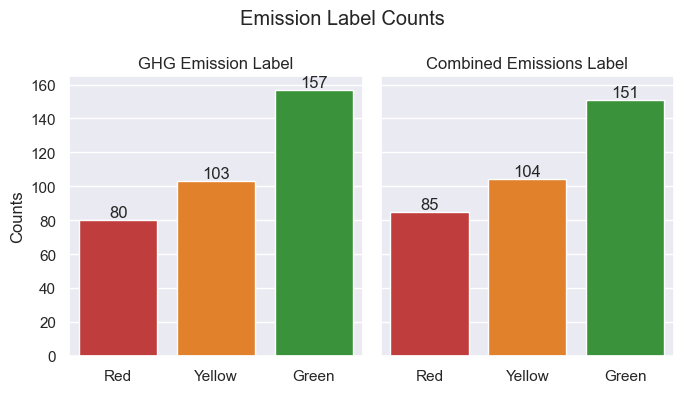

In [25]:
# THE BLUE BAR REPRESENTS THE SUM ROW WHICH IS THE TOTAL NUMBER OF RECIPES THAT HAVE BEEN ASSIGNED A LABEL
# EACH BAR REPRESENTS THE # OF RECIPES THAT WERE LABELLED WITH THAT SPECIFIC COLOUR

fig = create_visualizations(counts)
fig

In [26]:
final2.head()

,Category,Displayed Name,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,ALF,Flatbread,R-61778,ALF|Flatbread|4 Cheese,OK - AL FORNO,185.0,1229.947500,11.939000,1.900350,212.84,10662.59,664.84,6.45,115.05,5763.56,1.03,Red,Red
1,ALF,Flatbread,R-61780,ALF|Flatbread|Apple & Pancetta,OK - AL FORNO,140.0,756.345750,9.031250,1.444975,144.99,5287.95,540.25,6.45,103.56,3777.11,1.03,Red,Red
2,ALF,Flatbread,R-61749,ALF|Flatbread|BBQ Chicken,OK - AL FORNO,245.0,981.552616,19.022339,2.129034,118.33,3210.73,400.63,7.76,48.30,1310.50,0.87,Red,Red
3,ALF,Flatbread,R-61737,ALF|Flatbread|Beef & Onion,OK - AL FORNO,275.0,5941.689726,48.329753,17.611709,295.77,11470.53,2160.61,17.57,107.55,4171.10,6.40,Red,Red
4,ALF,Flatbread,R-68122,ALF|Flatbread|Beef Onion|TMRW,OK - AL FORNO,275.0,595.867326,4.985886,1.130669,72.63,3286.07,216.68,1.81,26.41,1194.93,0.41,Yellow,Yellow


In [27]:
final3 = final2.drop(columns=['Category', 'Displayed Name', 'Weight (g)', 'GHG Only Label'])

In [28]:
final3.head()

,ProdId,Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,R-61778,ALF|Flatbread|4 Cheese,OK - AL FORNO,1229.947500,11.939000,1.900350,212.84,10662.59,664.84,6.45,115.05,5763.56,1.03,Red
1,R-61780,ALF|Flatbread|Apple & Pancetta,OK - AL FORNO,756.345750,9.031250,1.444975,144.99,5287.95,540.25,6.45,103.56,3777.11,1.03,Red
2,R-61749,ALF|Flatbread|BBQ Chicken,OK - AL FORNO,981.552616,19.022339,2.129034,118.33,3210.73,400.63,7.76,48.30,1310.50,0.87,Red
3,R-61737,ALF|Flatbread|Beef & Onion,OK - AL FORNO,5941.689726,48.329753,17.611709,295.77,11470.53,2160.61,17.57,107.55,4171.10,6.40,Red
4,R-68122,ALF|Flatbread|Beef Onion|TMRW,OK - AL FORNO,595.867326,4.985886,1.130669,72.63,3286.07,216.68,1.81,26.41,1194.93,0.41,Yellow


In [29]:
final3.rename(columns={'ProdId': 'Optimum Control ID', 'Description': 'OC Description'}, inplace=True)

In [30]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,R-61778,ALF|Flatbread|4 Cheese,OK - AL FORNO,1229.947500,11.939000,1.900350,212.84,10662.59,664.84,6.45,115.05,5763.56,1.03,Red
1,R-61780,ALF|Flatbread|Apple & Pancetta,OK - AL FORNO,756.345750,9.031250,1.444975,144.99,5287.95,540.25,6.45,103.56,3777.11,1.03,Red
2,R-61749,ALF|Flatbread|BBQ Chicken,OK - AL FORNO,981.552616,19.022339,2.129034,118.33,3210.73,400.63,7.76,48.30,1310.50,0.87,Red
3,R-61737,ALF|Flatbread|Beef & Onion,OK - AL FORNO,5941.689726,48.329753,17.611709,295.77,11470.53,2160.61,17.57,107.55,4171.10,6.40,Red
4,R-68122,ALF|Flatbread|Beef Onion|TMRW,OK - AL FORNO,595.867326,4.985886,1.130669,72.63,3286.07,216.68,1.81,26.41,1194.93,0.41,Yellow


In [31]:
final3['Red'] = final3['Combined Label'] == 'Red'
final3['Yellow'] = final3['Combined Label'] == 'Yellow'
final3['Green'] = final3['Combined Label'] == 'Green'

In [32]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label,Red,Yellow,Green
0,R-61778,ALF|Flatbread|4 Cheese,OK - AL FORNO,1229.947500,11.939000,1.900350,212.84,10662.59,664.84,6.45,115.05,5763.56,1.03,Red,True,False,False
1,R-61780,ALF|Flatbread|Apple & Pancetta,OK - AL FORNO,756.345750,9.031250,1.444975,144.99,5287.95,540.25,6.45,103.56,3777.11,1.03,Red,True,False,False
2,R-61749,ALF|Flatbread|BBQ Chicken,OK - AL FORNO,981.552616,19.022339,2.129034,118.33,3210.73,400.63,7.76,48.30,1310.50,0.87,Red,True,False,False
3,R-61737,ALF|Flatbread|Beef & Onion,OK - AL FORNO,5941.689726,48.329753,17.611709,295.77,11470.53,2160.61,17.57,107.55,4171.10,6.40,Red,True,False,False
4,R-68122,ALF|Flatbread|Beef Onion|TMRW,OK - AL FORNO,595.867326,4.985886,1.130669,72.63,3286.07,216.68,1.81,26.41,1194.93,0.41,Yellow,False,True,False


In [33]:
import pandas as pd


desired_column_order = [
    'Optimum Control ID', 'OC Description', 'SalesGroup', 'Combined Label', 'Red', 'Yellow', 'Green',
    'GHG Emission (g)', 'N lost (g)', 'Land Use (m^2)', 'Freshwater Withdrawals (L)', 
    'Stress-Weighted Water Use (L)', 'GHG Emission (g) / 100g', 'N lost (g) / 100g', 
    'Freshwater Withdrawals (L) / 100g', 'Stress-Weighted Water Use (L) / 100g', 
    'Land Use (m^2) / 100g'
]

# Create a new DataFrame with the desired column order
data_reordered = final3[desired_column_order]

# Print the reordered DataFrame
data_reordered.head()


,Optimum Control ID,OC Description,SalesGroup,Combined Label,Red,Yellow,Green,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,R-61778,ALF|Flatbread|4 Cheese,OK - AL FORNO,Red,True,False,False,1229.947500,11.939000,1.900350,212.84,10662.59,664.84,6.45,115.05,5763.56,1.03
1,R-61780,ALF|Flatbread|Apple & Pancetta,OK - AL FORNO,Red,True,False,False,756.345750,9.031250,1.444975,144.99,5287.95,540.25,6.45,103.56,3777.11,1.03
2,R-61749,ALF|Flatbread|BBQ Chicken,OK - AL FORNO,Red,True,False,False,981.552616,19.022339,2.129034,118.33,3210.73,400.63,7.76,48.30,1310.50,0.87
3,R-61737,ALF|Flatbread|Beef & Onion,OK - AL FORNO,Red,True,False,False,5941.689726,48.329753,17.611709,295.77,11470.53,2160.61,17.57,107.55,4171.10,6.40
4,R-68122,ALF|Flatbread|Beef Onion|TMRW,OK - AL FORNO,Yellow,False,True,False,595.867326,4.985886,1.130669,72.63,3286.07,216.68,1.81,26.41,1194.93,0.41


In [34]:
data_reordered.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Labelled_Data_"+restaurant_name+"_for_nutrislice.csv",
                  index=False)